In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')


# ===============================
# 1. Data Preprocessing
# ===============================

In [330]:
# Load the dataset
data_path = "DataSet_4_Exam/AirQualityUCI.csv"
data = pd.read_csv(data_path, sep=';', decimal=',', na_values=-200)

# Remove the last two columns (empty)
data = data.iloc[:, :-2]

# Combine Date and Time into DateTime
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S')

# Set DateTime as the index
data.set_index('DateTime', inplace=True)

# Select columns
df = data[['CO(GT)', 'NO2(GT)', 'RH']]

print(df.isna().sum().sum()) # checking NaN numbers

# Drop NaN
df.dropna(inplace=True)


4033


In [331]:
print(df.index.freq)

None


In [332]:
df = df.asfreq('H')
print(df.isna().sum().sum()) # checking NaN numbers
df.dropna(inplace=True)

# Ensure DateTime index is of datetime type
df.index = pd.to_datetime(df.index)

# Convert data types to float
df = df.astype(float)

7248


# ===============================
# 2. Exploratory Data Analysis (EDA)
# ===============================

In [333]:
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6941 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CO(GT)   6941 non-null   float64
 1   NO2(GT)  6941 non-null   float64
 2   RH       6941 non-null   float64
dtypes: float64(3)
memory usage: 216.9 KB
None
            CO(GT)      NO2(GT)           RH
count  6941.000000  6941.000000  6941.000000
mean      2.182467   113.874082    48.881905
std       1.441158    47.475017    17.433193
min       0.100000     2.000000     9.200000
25%       1.100000    79.000000    35.300000
50%       1.900000   110.000000    49.200000
75%       2.900000   142.000000    62.200000
max      11.900000   333.000000    88.700000


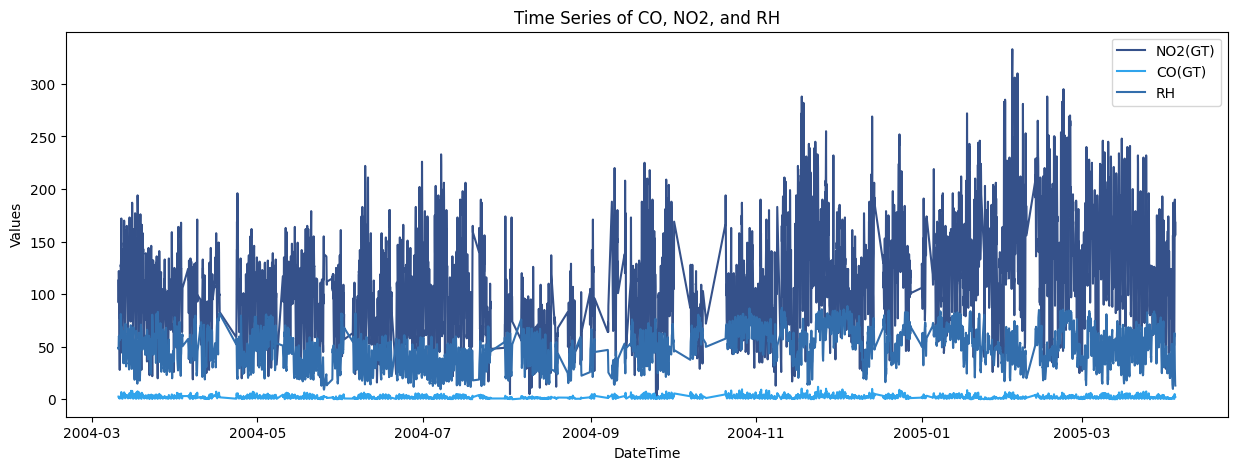

In [334]:
# Plot the time series
plt.figure(figsize=(15, 5))
plt.plot(df['NO2(GT)'], color='#35518A', label='NO2(GT)')
plt.plot(df['CO(GT)'], color='#30A4EC', label='CO(GT)')
plt.plot(df['RH'], color='#336EAC', label='RH')

plt.title('Time Series of CO, NO2, and RH')
plt.xlabel('DateTime')
plt.ylabel('Values')
plt.legend()
plt.show()



In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

# List of variable pairs to test
variable_pairs = [('CO(GT)', 'NO2(GT)'),
                  ('CO(GT)', 'RH'),
                  ('NO2(GT)', 'CO(GT)'),
                  ('NO2(GT)', 'RH'),
                  ('RH', 'CO(GT)'),
                  ('RH', 'NO2(GT)')]

# Maximum number of lags
max_lag = 5

# Perform Granger Causality tests for all pairs
for x, y in variable_pairs:
    print(f"Testing if {x} Granger-causes {y}")
    results = grangercausalitytests(df[[x, y]], maxlag=max_lag, verbose=False)
    for lag, result in results.items():
        p_value = result[0]['ssr_ftest'][1]
        print(f"Lag {lag} p-value: {p_value:.5f}")
    print("\n")


Testing if CO(GT) Granger-causes NO2(GT)
Lag 1 p-value: 0.03219
Lag 2 p-value: 0.00000
Lag 3 p-value: 0.00000
Lag 4 p-value: 0.00000
Lag 5 p-value: 0.00000


Testing if CO(GT) Granger-causes RH
Lag 1 p-value: 0.16587
Lag 2 p-value: 0.29038
Lag 3 p-value: 0.00264
Lag 4 p-value: 0.00511
Lag 5 p-value: 0.00000


Testing if NO2(GT) Granger-causes CO(GT)
Lag 1 p-value: 0.00271
Lag 2 p-value: 0.00000
Lag 3 p-value: 0.00000
Lag 4 p-value: 0.00000
Lag 5 p-value: 0.00000


Testing if NO2(GT) Granger-causes RH
Lag 1 p-value: 0.55955
Lag 2 p-value: 0.03950
Lag 3 p-value: 0.07579
Lag 4 p-value: 0.01889
Lag 5 p-value: 0.00002


Testing if RH Granger-causes CO(GT)
Lag 1 p-value: 0.05055
Lag 2 p-value: 0.00000
Lag 3 p-value: 0.00000
Lag 4 p-value: 0.00000
Lag 5 p-value: 0.00000


Testing if RH Granger-causes NO2(GT)
Lag 1 p-value: 0.15654
Lag 2 p-value: 0.00000
Lag 3 p-value: 0.00000
Lag 4 p-value: 0.00000
Lag 5 p-value: 0.00000




Correlation Matrix:
           CO(GT)   NO2(GT)        RH
CO(GT)   1.000000  0.673840  0.064753
NO2(GT)  0.673840  1.000000 -0.075333
RH       0.064753 -0.075333  1.000000


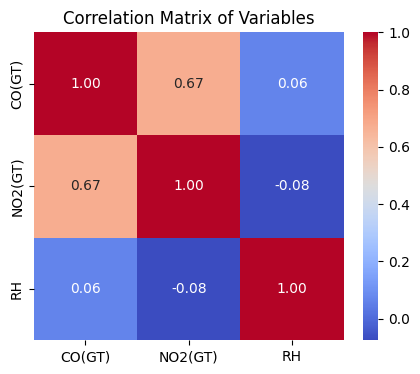

In [ ]:

correlation_matrix = df.corr()

print("Correlation Matrix:")
print(correlation_matrix)

# Plot correlation matrix
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Variables')
plt.show()


In [337]:
# Check for stationarity using Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'ADF Test: {title}')
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("=> The series is stationary.\n")
    else:
        print("=> The series is non-stationary.\n")

for column in df.columns:
    adf_test(df[column], title=column)

ADF Test: CO(GT)
ADF Statistic            -9.894641e+00
p-value                   3.484035e-17
#Lags Used                3.200000e+01
Number of Observations    6.908000e+03
Critical Value (1%)      -3.431297e+00
Critical Value (5%)      -2.861958e+00
Critical Value (10%)     -2.566993e+00
=> The series is stationary.

ADF Test: NO2(GT)
ADF Statistic            -7.223010e+00
p-value                   2.087551e-10
#Lags Used                3.200000e+01
Number of Observations    6.908000e+03
Critical Value (1%)      -3.431297e+00
Critical Value (5%)      -2.861958e+00
Critical Value (10%)     -2.566993e+00
=> The series is stationary.

ADF Test: RH
ADF Statistic            -7.399081e+00
p-value                   7.639367e-11
#Lags Used                2.400000e+01
Number of Observations    6.916000e+03
Critical Value (1%)      -3.431296e+00
Critical Value (5%)      -2.861958e+00
Critical Value (10%)     -2.566992e+00
=> The series is stationary.



In [338]:
from statsmodels.tsa.stattools import kpss

def perform_kpss_test(series, regression_type='c'):
    print(f"KPSS Test for {series.name}:")
    kpss_stat, p_value, lags, critical_values = kpss(series, regression=regression_type)

    print(f"KPSS Statistic: {kpss_stat}")
    print(f"p-value: {p_value}")
    print(f"Lags Used: {lags}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"    {key}: {value}")

    if p_value < 0.05:
        print("The series is likely non-stationary (Reject Null Hypothesis).")
    else:
        print("The series is likely stationary (Fail to Reject Null Hypothesis).")
    print("\n")

# Apply KPSS test on each variable in your residuals DataFrame
for column in df.columns:
    perform_kpss_test(df[column])


KPSS Test for CO(GT):
KPSS Statistic: 0.5305158613003496
p-value: 0.0347937249323537
Lags Used: 37
Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely non-stationary (Reject Null Hypothesis).


KPSS Test for NO2(GT):
KPSS Statistic: 6.216917783944597
p-value: 0.01
Lags Used: 43
Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely non-stationary (Reject Null Hypothesis).


KPSS Test for RH:
KPSS Statistic: 2.472769044932895
p-value: 0.01
Lags Used: 47
Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely non-stationary (Reject Null Hypothesis).




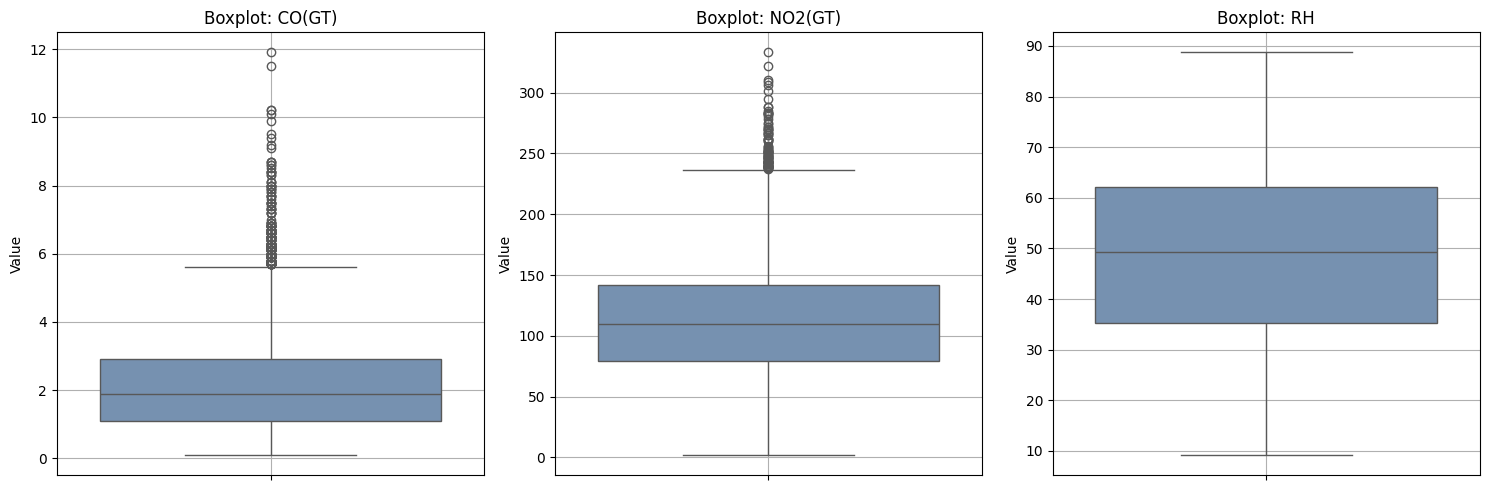

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot for each variable - original df
plt.figure(figsize=(15, 5))

for i, var in enumerate(df.columns, start=1):
    plt.subplot(1, len(df.columns), i)  # subplot for each variable
    sns.boxplot(y=df[var], color='#6D90B9')
    plt.title(f'Boxplot: {var}')
    plt.ylabel('Value')
    plt.grid(True)

plt.tight_layout()
plt.show()


# ===============================
# 3. Data Splitting and Transformation
# ===============================


Training set size: 5899
Test set size: 1042

Checking for NaNs in scaled training data:
CO(GT)     0
NO2(GT)    0
RH         0
dtype: int64

Checking for NaNs in scaled testing data:
CO(GT)     0
NO2(GT)    0
RH         0
dtype: int64


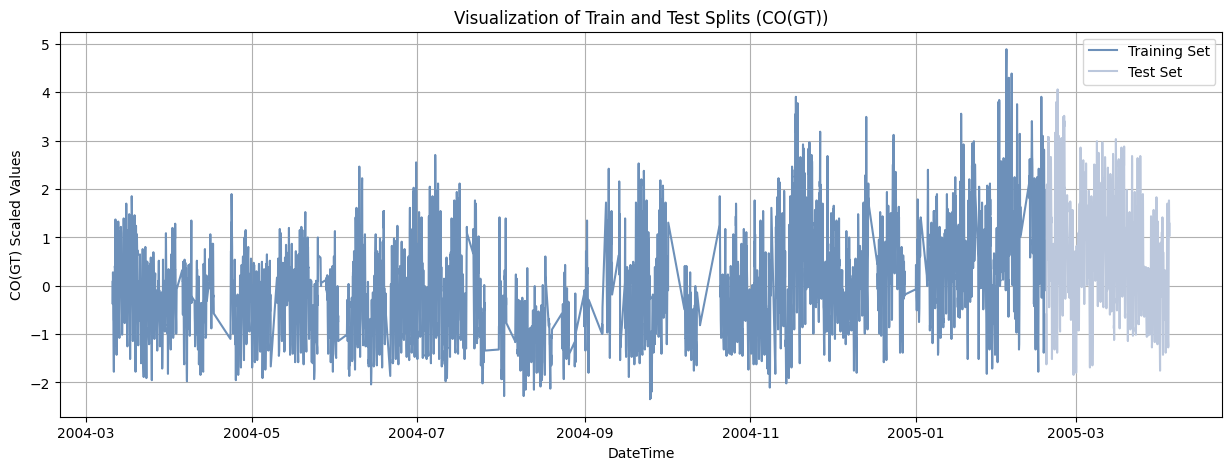

In [ ]:

# Split the data into train and test
train_size = int(len(df) * 0.85)  # 85% training
test_size = len(df) - train_size   # 15% testing

# Create the splits
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

print("Training set size:", len(train))
print("Test set size:", len(test))

# Initialize separate scalers for each variable
scalers = {}
for var in df.columns:
    scalers[var] = StandardScaler()
    scalers[var].fit(train[[var]])

# Transform the datasets
train_scaled = pd.DataFrame(index=train.index)
test_scaled = pd.DataFrame(index=test.index)

for var in df.columns:
    train_scaled[var] = scalers[var].transform(train[[var]])
    test_scaled[var] = scalers[var].transform(test[[var]])

# Verify no NaNs in scaled data
print("\nChecking for NaNs in scaled training data:")
print(train_scaled.isna().sum())
print("\nChecking for NaNs in scaled testing data:")
print(test_scaled.isna().sum())

# Plot the splits for CO(GT) data
plt.figure(figsize=(15, 5))
plt.plot(train_scaled.index, train_scaled['NO2(GT)'], label='Training Set', color='#6D90B9')
plt.plot(test_scaled.index, test_scaled['NO2(GT)'], label='Test Set', color='#BBC7DC')
plt.title('Visualization of Train and Test Splits (CO(GT))')
plt.xlabel('DateTime')
plt.ylabel('CO(GT) Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

# ===============================
# 4. Model Implementation: VAR
# ===============================

In [ ]:

# select the optimal lag order
model = VAR(train_scaled)
lag_order_results = model.select_order(maxlags=30)
print("\nLag Order Selection based on Training Set:")
print(lag_order_results.summary())

optimal_lag = int(lag_order_results.bic + (abs(lag_order_results.aic - lag_order_results.bic)/2))
print(f"\nOptimal lag order selected by AIC: {optimal_lag}")



Lag Order Selection based on Training Set:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -0.7381     -0.7347      0.4780     -0.7370
1       -5.947      -5.933    0.002615      -5.942
2       -6.248      -6.224    0.001935      -6.240
3       -6.303      -6.269    0.001830      -6.292
4       -6.331      -6.287    0.001779      -6.316
5       -6.351      -6.296    0.001746      -6.332
6       -6.368      -6.303    0.001715      -6.346
7       -6.394      -6.319    0.001672      -6.368
8       -6.417      -6.331    0.001634      -6.387
9       -6.447      -6.351    0.001585      -6.414
10      -6.476      -6.370    0.001540      -6.439
11      -6.488      -6.372    0.001521      -6.448
12      -6.508      -6.382    0.001492      -6.464
13      -6.536      -6.399    0.001451      -6.488
14      -6.542      -6.395    0.001442      -6.491
15      -6.548      -6.391    0.001433

In [ ]:
# Fit VAR model
var_model = model.fit(optimal_lag)
print("\nVAR Model Summary on Training Set:")
print(var_model.summary())

# Check for model stability
print("\nIs the VAR model stable?", var_model.is_stable())


VAR Model Summary on Training Set:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 09, Dec, 2024
Time:                     02:57:53
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -6.45794
Nobs:                     5875.00    HQIC:                  -6.62034
Log likelihood:          -5088.31    FPE:                 0.00122247
AIC:                     -6.70689    Det(Omega_mle):      0.00117801
--------------------------------------------------------------------
Results for equation CO(GT)
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.000522         0.006332           -0.082           0.934
L1.CO(GT)           0.885200         0.017400           50.873           0.000
L1.NO2(GT)          0.098479   

# ===============================
# 5. Forecasting with VAR
# ===============================

In [343]:
# Forecast on test set
forecast_steps = len(test_scaled)
forecast_input = train_scaled.values[-optimal_lag:]
forecast = var_model.forecast(y=forecast_input, steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=test_scaled.index, columns=test_scaled.columns)

print('\nForecasted Values for CO(GT), NO2(GT), and RH on Test Set:')
print(forecast_df.head())

# Inverse transform the forecasts and actuals
df_pred = pd.DataFrame(index=forecast_df.index, columns=forecast_df.columns)
df_actual = pd.DataFrame(index=test_scaled.index, columns=test_scaled.columns)

for var in df.columns:
    df_pred[var] = scalers[var].inverse_transform(forecast_df[var].values.reshape(-1, 1)).flatten()
    df_actual[var] = scalers[var].inverse_transform(test_scaled[var].values.reshape(-1, 1)).flatten()


Forecasted Values for CO(GT), NO2(GT), and RH on Test Set:
                       CO(GT)   NO2(GT)        RH
DateTime                                         
2005-02-18 02:00:00 -0.722445  0.269802  0.022183
2005-02-18 05:00:00 -0.756567 -0.079719  0.084735
2005-02-18 06:00:00 -0.574065  0.002108  0.123104
2005-02-18 07:00:00 -0.306622  0.533967  0.178310
2005-02-18 08:00:00 -0.042559  1.092641  0.168930


# ===============================
# 6. Evaluation Metrics
# ===============================

In [ ]:
metrics = {}

for var in df.columns:
    rmse = np.sqrt(mean_squared_error(df_actual[var], df_pred[var]))
    mae = mean_absolute_error(df_actual[var], df_pred[var])
    metrics[var] = {'RMSE': rmse, 'MAE': mae}
    print(f"{var} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")


CO(GT) - RMSE: 1.3137, MAE: 1.0592
NO2(GT) - RMSE: 54.1367, MAE: 43.0682
RH - RMSE: 17.8101, MAE: 14.9613


# ===============================
# 7. Plotting the Forecast Results
# ===============================

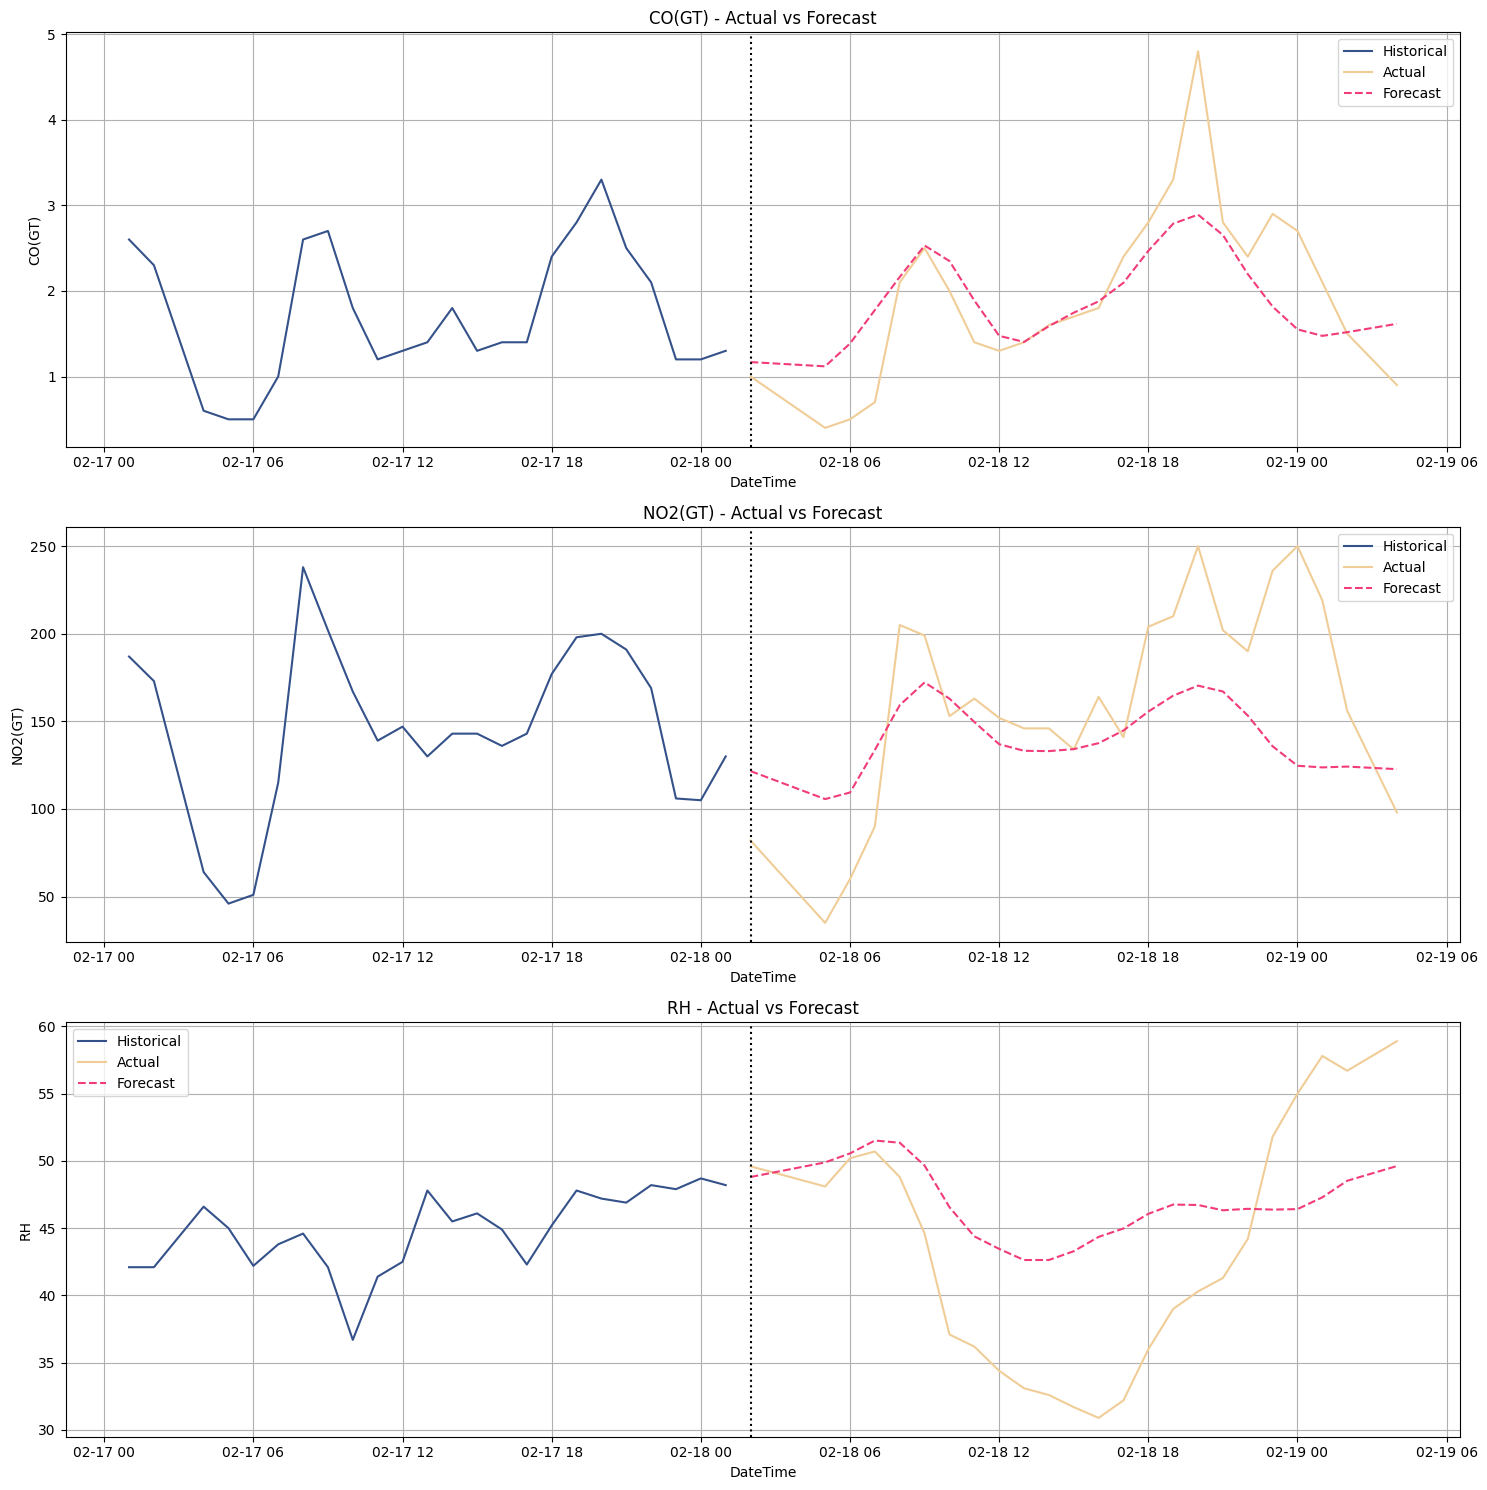

In [ ]:
# Define the number of points to plot
num_points = 24

# Plot the results
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

variables = ['CO(GT)', 'NO2(GT)', 'RH']

for i, var in enumerate(variables):
    # Historical data (last `num_points` before test set)
    hist_start_idx = -(len(test) + num_points)
    hist_end_idx = -len(test)
    axes[i].plot(
        df.index[hist_start_idx:hist_end_idx],
        df[var].iloc[hist_start_idx:hist_end_idx],
        label='Historical',
        color='#35518A'
    )
    
    # Actual test data (first `num_points` of test set)
    axes[i].plot(
        df_actual.index[:num_points],
        df_actual[var].iloc[:num_points],
        label='Actual',
        color='#F0CD97'
    )
    
    # Forecasted data (first `num_points` of forecast)
    axes[i].plot(
        df_pred.index[:num_points],
        df_pred[var].iloc[:num_points],
        label='Forecast',
        color='#F13C77',
        linestyle='--'
    )
    
    # Vertical line to indicate the transition
    axes[i].axvline(x=test.index[0], color='black', linestyle=':')
    
    axes[i].set_title(f'{var} - Actual vs Forecast')
    axes[i].set_xlabel('DateTime')
    axes[i].set_ylabel(var)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


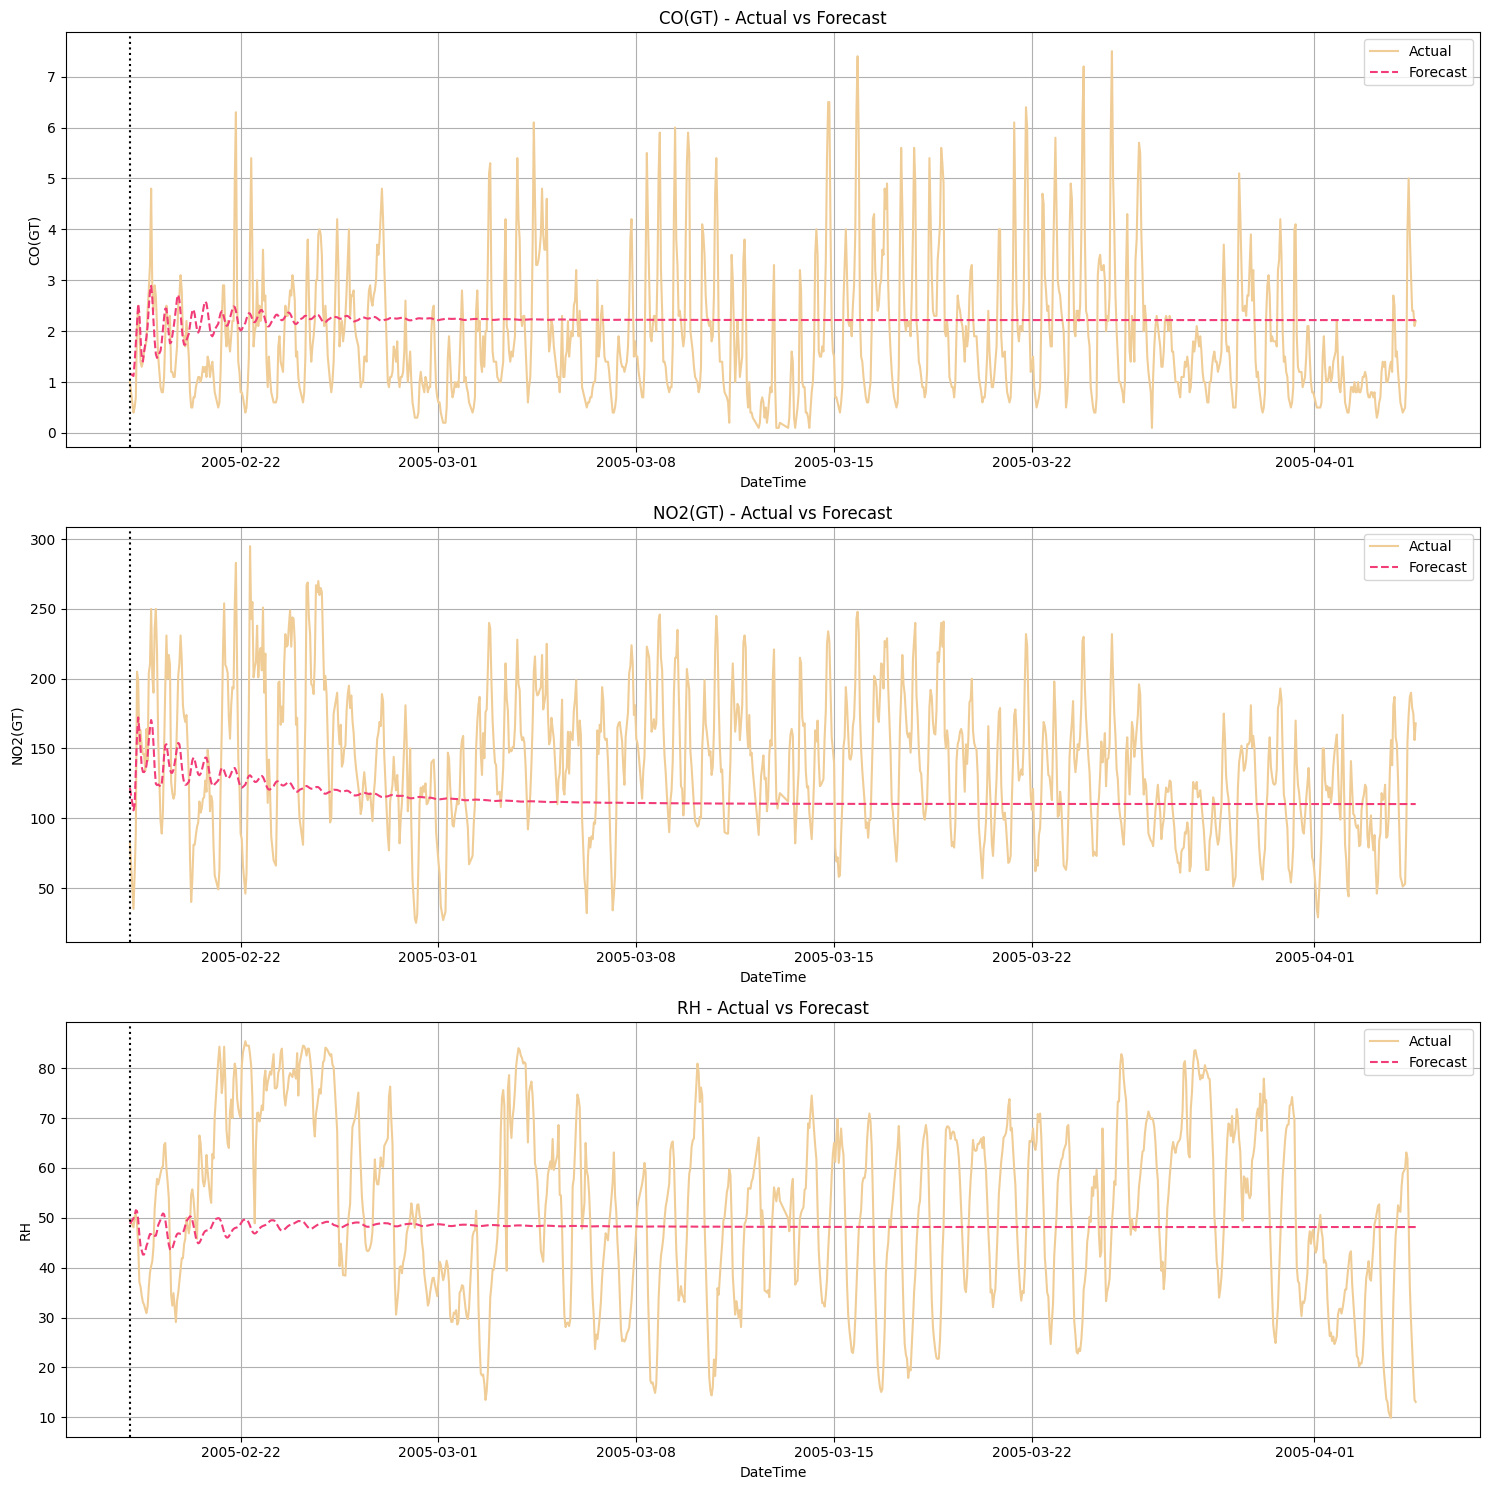

In [ ]:

num_points = (len(test))

# Plot the results
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

variables = ['CO(GT)', 'NO2(GT)', 'RH']

for i, var in enumerate(variables):
    # Actual test data (first `num_points` of test set)
    axes[i].plot(
        df_actual.index[:num_points],
        df_actual[var].iloc[:num_points],
        label='Actual',
        color='#F0CD97'
    )
    
    # Forecasted data (first `num_points` of forecast)
    axes[i].plot(
        df_pred.index[:num_points],
        df_pred[var].iloc[:num_points],
        label='Forecast',
        color='#F13C77',
        linestyle='--'
    )
    
    # Vertical line to indicate the transition
    axes[i].axvline(x=test.index[0], color='black', linestyle=':')
    
    axes[i].set_title(f'{var} - Actual vs Forecast')
    axes[i].set_xlabel('DateTime')
    axes[i].set_ylabel(var)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


# ===============================
# 8. Evaluation Analysis
# ===============================

In [346]:
print("\nEvaluation Metrics:")
for var in variables:
    print(f"{var} - RMSE: {metrics[var]['RMSE']:.4f}, MAE: {metrics[var]['MAE']:.4f}")


Evaluation Metrics:
CO(GT) - RMSE: 1.3137, MAE: 1.0592
NO2(GT) - RMSE: 54.1367, MAE: 43.0682
RH - RMSE: 17.8101, MAE: 14.9613


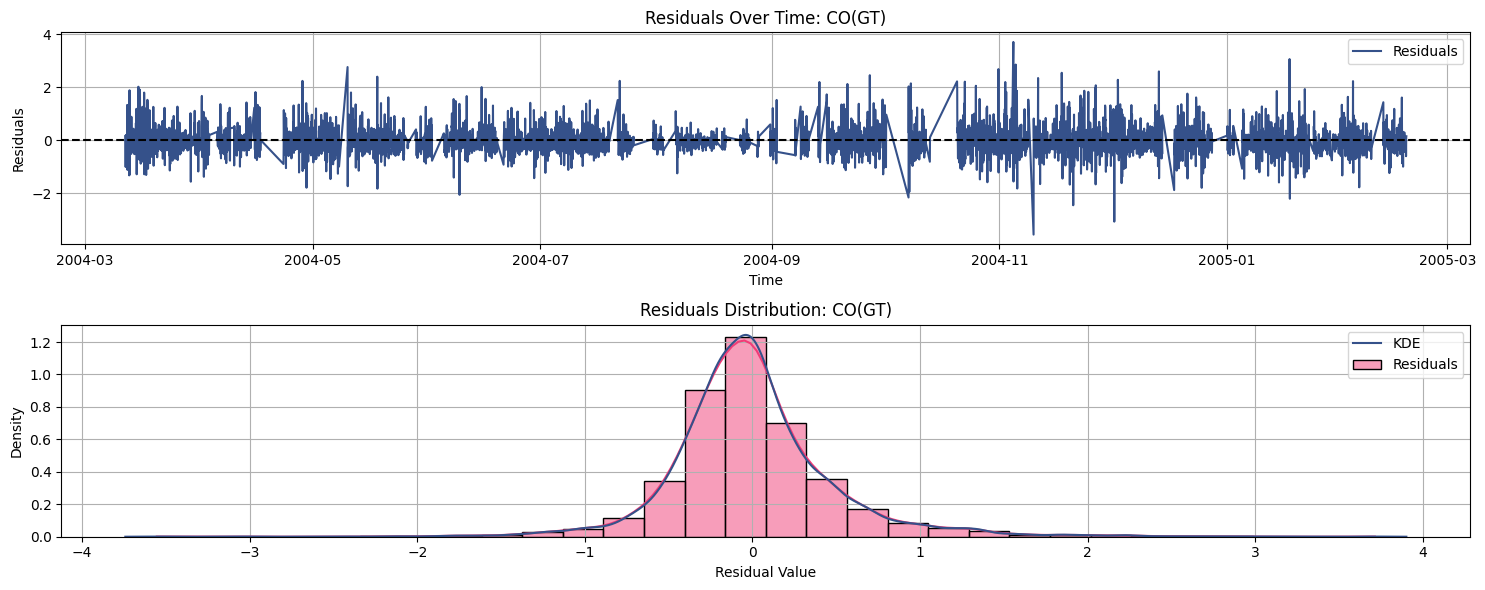

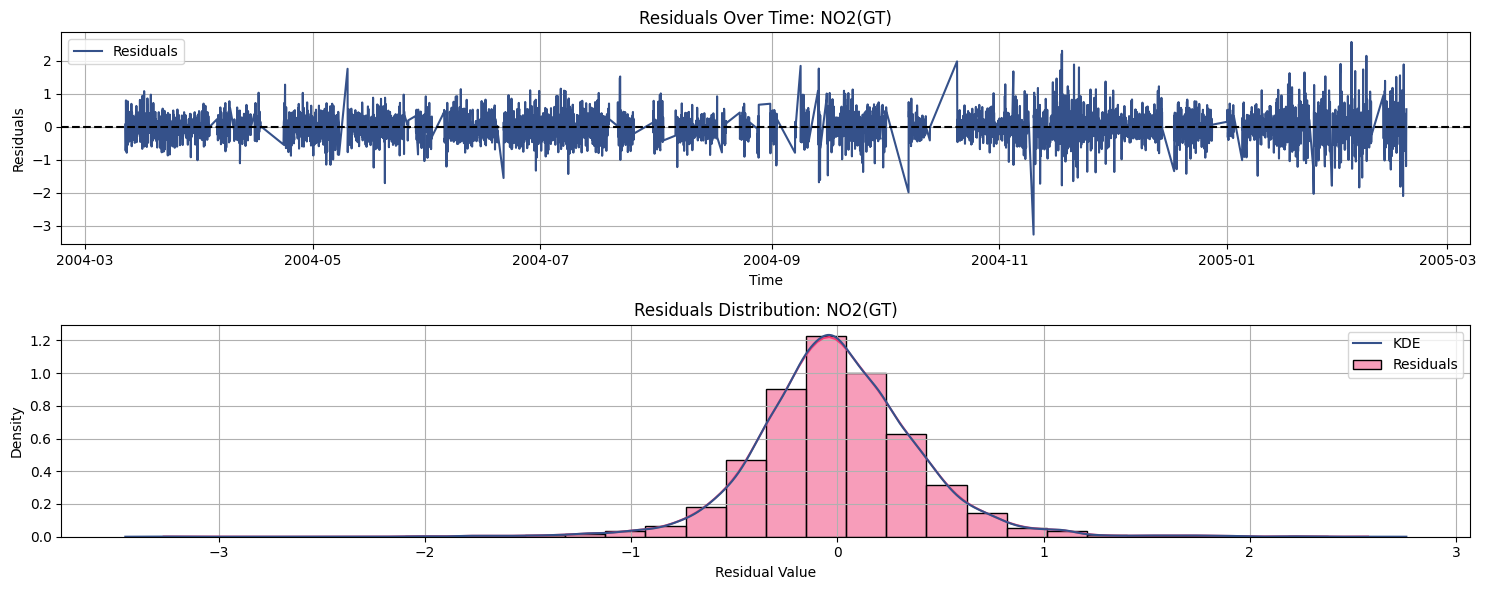

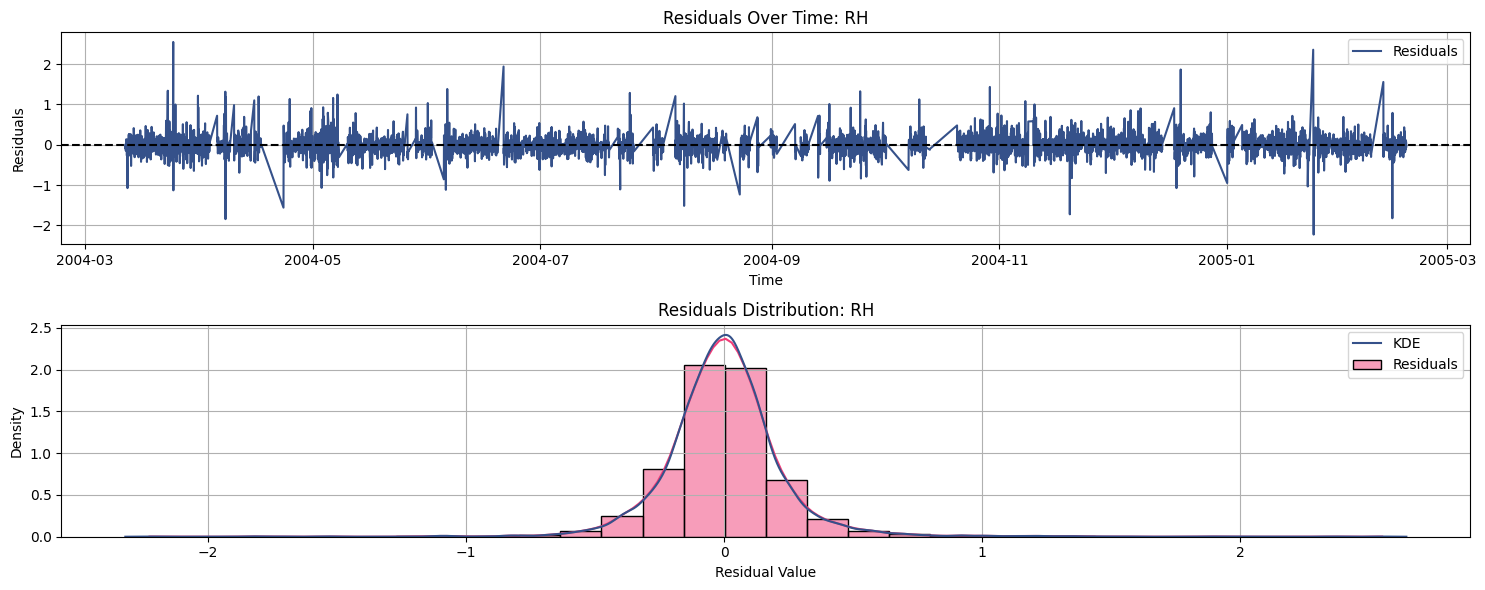

In [ ]:
# Get residuals
residuals = var_model.resid

# Function to plot residuals
def plot_residuals(variable):
    residuals_var = residuals[variable]
    
    # Plot Residuals Over Time
    plt.figure(figsize=(15, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(residuals_var, label='Residuals', color='#35518A')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title(f'Residuals Over Time: {variable}')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.grid(True)
    
    # Plot Residuals Distribution
    plt.subplot(2, 1, 2)
    sns.histplot(residuals_var, kde=True, bins=30, stat='density', label='Residuals', color='#F13C77')
    residuals_kde = sm.nonparametric.KDEUnivariate(residuals_var)
    residuals_kde.fit()
    plt.plot(residuals_kde.support, residuals_kde.density, label='KDE', color='#35518A')
    plt.title(f'Residuals Distribution: {variable}')
    plt.xlabel('Residual Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# List of variables
variables = residuals.columns

# Plot residuals for each variable
for var in variables:
    plot_residuals(var)


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

# residuals diagnostic
for var in residuals.columns:  # Iterate over each variable
    residuals_var = residuals[var]

    # Ljung-Box Test for autocorrelation
    lb_test = acorr_ljungbox(residuals_var, lags=[27], return_df=True)
    print(f"Ljung-Box Test for {var}:")
    print(lb_test)

    # Shapiro-Wilk Test for normality
    shapiro_test = shapiro(residuals_var)
    print(f"Shapiro-Wilk Test for {var}: p-value = {shapiro_test.pvalue:.64f}\n")

Ljung-Box Test for CO(GT):
      lb_stat  lb_pvalue
27  15.027418   0.969046
Shapiro-Wilk Test for CO(GT): p-value = 0.0000000000000000000000000000000000000000000000980643341205094501

Ljung-Box Test for NO2(GT):
     lb_stat  lb_pvalue
27  26.10278   0.512902
Shapiro-Wilk Test for NO2(GT): p-value = 0.0000000000000000000000000000000000343745252063002461230696022528

Ljung-Box Test for RH:
      lb_stat  lb_pvalue
27  17.464535   0.919034
Shapiro-Wilk Test for RH: p-value = 0.0000000000000000000000000000000000000000000000000000379350610666



# ===============================
# 9. Rolling Statistics
# ===============================

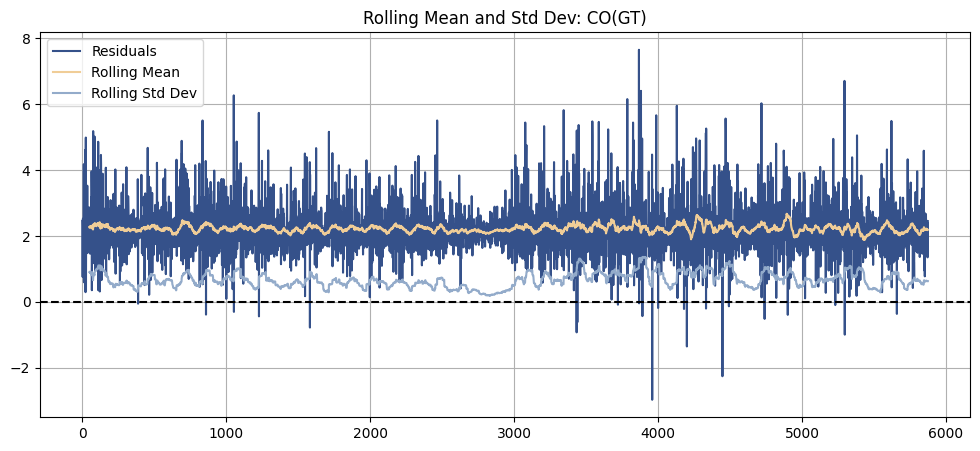

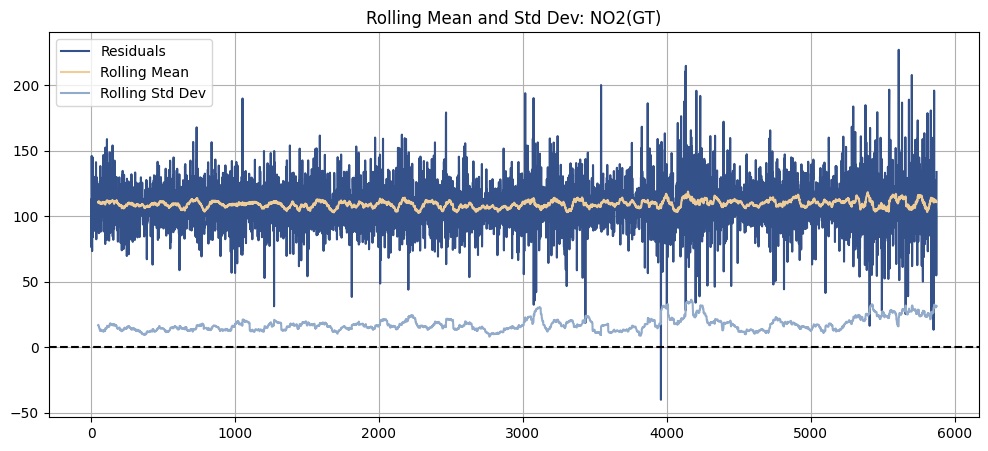

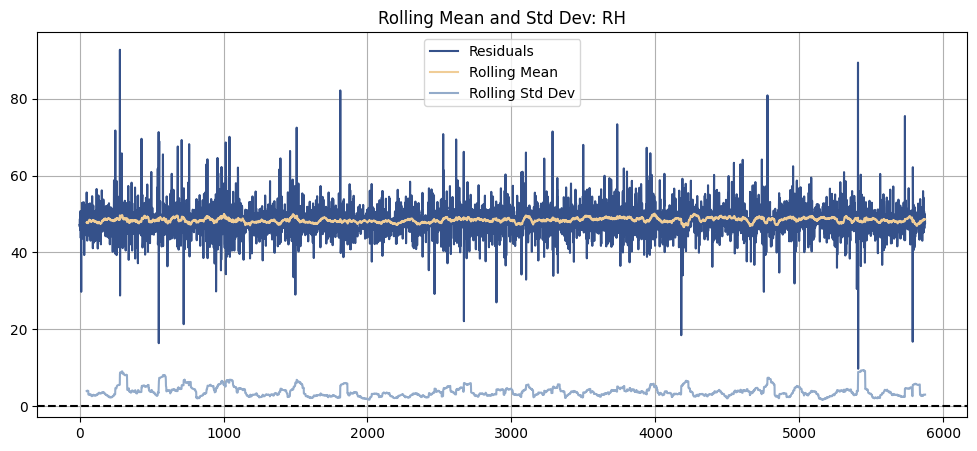

In [349]:

for var in variables:
    residuals_var = residuals[var]
    residuals_inv = scalers[var].inverse_transform(residuals_var.values.reshape(-1, 1)).flatten()
    rolling_mean = pd.Series(residuals_inv).rolling(window=50).mean()
    rolling_std = pd.Series(residuals_inv).rolling(window=50).std()

    plt.figure(figsize=(12, 5))
    plt.plot(residuals_inv, label='Residuals', color='#35518A')
    plt.plot(rolling_mean, label='Rolling Mean', color='#F0CD97')
    plt.plot(rolling_std, label='Rolling Std Dev', color='#93ABCA')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title(f'Rolling Mean and Std Dev: {var}')
    plt.legend()
    plt.grid(True)
    plt.show()